# Classification Model Student Profile
This program is used to predict a student's profile based on grades, interests and many other parameters.

## Importation of librairies

In [5]:
import pandas as pd
import keras
from keras.utils import FeatureSpace
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np

## Configure tensorflow thread allocation

In [ ]:
tf.config.threading.set_inter_op_parallelism_threads(6)

## Load dataframe and get classes names

In [6]:
dataframe = pd.read_csv('data/dataset.csv')
DATASET_SIZE = dataframe.shape[0]
CLASS_NAMES = set(dataframe.specification.unique())

## Data standardization

In [7]:
def normalization(dataframe):
    dataframe = dataframe.drop('student_id', axis=1)
    dataframe = dataframe.fillna("")
    label_encoder = LabelEncoder()
    dataframe.specification = label_encoder.fit_transform(dataframe.specification)
    dataframe.specification = dataframe.specification.astype('category')
    return dataframe

dataframe = normalization(dataframe)

## Separation between train (80%) and test (20%) and conversion to tensorflow Dataset

In [8]:
def dataframe_to_dataset(dataframe):
    catpop = dataframe.pop("specification")
    category = pd.get_dummies(catpop, prefix='Specification')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), category))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

test_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(test_dataframe.index)

test_ds = dataframe_to_dataset(test_dataframe)
train_ds = dataframe_to_dataset(train_dataframe)

test_ds = test_ds.batch(32)
train_ds = train_ds.batch(32)

2023-06-08 10:37:56.920567: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Creation of normalization parameters

In [9]:
fs = FeatureSpace(
    features={
        "iq":"float_normalized",
        "interest_outside_school": "string_categorical",
        "interest_outside_school_2": "string_categorical",
        "interest_outside_school_3": "string_categorical",
        "interest_outside_school_4": "string_categorical",
        "favorite_subject_it": "string_categorical",
        "favorite_subject_it_2": "string_categorical",
        "favorite_subject_it_3": "string_categorical",
        "favorite_subject_it_4": "string_categorical",
        "name": "string_categorical",
        "hobbies": "string_categorical",
        "hobbies_2": "string_categorical",
        "hobbies_3": "string_categorical",
        "hobbies_4": "string_categorical",
        "hobbies_5": "string_categorical",
        "hobbies_6": "string_categorical",
        "hobbies_7": "string_categorical",
        "hobbies_8": "string_categorical",
        "hobbies_9": "string_categorical",
        "junior_network_administrator": "float_normalized",
        "junior_web_programmer": "float_normalized",
        "junior_programmer": "float_normalized",
    },
    output_mode="concat",
)

def extract_feature(x, _):
    return x

train_no_labels = train_ds.map(extract_feature)

fs.adapt(train_no_labels)

2023-06-08 10:37:57.579083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype string and shape [80000]
	 [[{{node Placeholder/_13}}]]
2023-06-08 10:37:57.582230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_21' with dtype string and shape [80000]
	 [[{{node Placeholder/_21}}]]
2023-06-08 10:37:58.526254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype string and shape

## Data presented according to FeatureSpace specifications

In [10]:
preprocessed_train_ds = train_ds.map(
    lambda x, y: (fs(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
preprocessed_train_ds = preprocessed_train_ds.prefetch(tf.data.AUTOTUNE)

preprocessed_test_ds = test_ds.map(
    lambda x, y: (fs(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
preprocessed_test_ds = preprocessed_test_ds.prefetch(tf.data.AUTOTUNE)

## Model creation

In [11]:
dataset_encoded = fs.get_encoded_features()
raw = fs.get_inputs()

x = keras.layers.Dense(32, activation="relu")(dataset_encoded)
x = keras.layers.Dense(32, activation="relu")(x)
predictions = keras.layers.Dense(len(CLASS_NAMES), activation="softmax")(x)

training_model = keras.Model(inputs=dataset_encoded, outputs=predictions)
inference_model = keras.Model(inputs=raw, outputs=predictions)


training_model.compile(loss="categorical_crossentropy",
                   optimizer="adam", metrics=['accuracy'])

inference_model.compile(loss="categorical_crossentropy",
                   optimizer="adam", metrics=['accuracy'])

## Train model
This function trains the model a number of times until it reaches the best accuracy.

In [43]:
# Modify the number of epochs if you want to test things
history = training_model.fit(
    preprocessed_train_ds, epochs=5, verbose=0,validation_data=preprocessed_test_ds
)

## Export graphs showing model accuracy and loss function

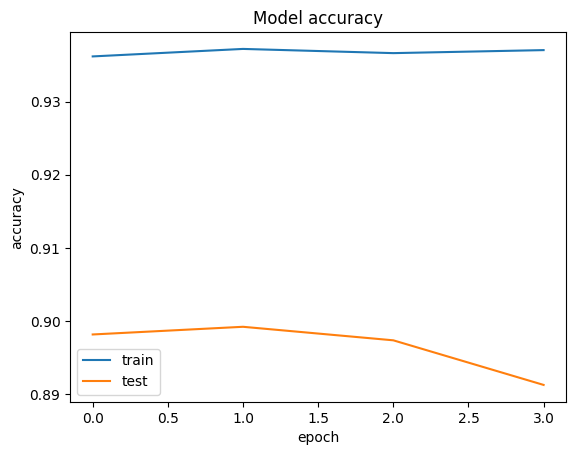

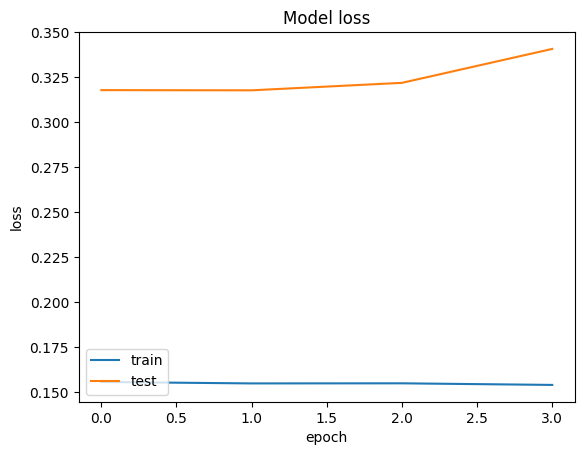

In [53]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')
plt.savefig('./architectures/accuracy.png')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')
plt.savefig('./architectures/loss.png')
plt.show()

## Export the model shape to an image
This function is used to export the model to a PNG image. The first one will export the model with the normalized parameters and the second one will export the model with RAW data.

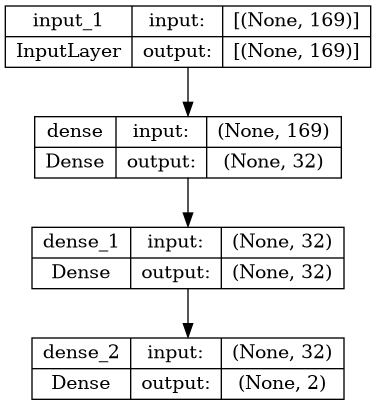

In [56]:
keras.utils.plot_model(inference_model, show_shapes=True,
                       to_file='./architectures/final_model.png')
keras.utils.plot_model(training_model, show_shapes=True,
                       to_file='./architectures/final_model_normalized.png')

## Save the model
This function is used to save the model with the weights and parameters to a single file that can be imported later and used directly.


In [ ]:
inference_model.save('./model/settings')